In [8]:
from matplotlib import pylab as plt
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pandas as pd
import seaborn as sns

sns.set(style='darkgrid', color_codes=True)
sns.set_context('talk')
sns.set_palette('dark')
rcParams['figure.figsize'] = (15, 5)
rcParams['savefig.pad_inches'] = 0.4

df_all = pd.concat([
    pd.read_csv('input/candle.{}.csv'.format(i)).assign(instrument=i, time=lambda d: pd.to_datetime(d['time']))
    for i in ['EUR_USD', 'USD_JPY', 'GBP_USD', 'AUD_USD']
]).set_index(['instrument', 'time'])
df_eur_usd = df_all.reset_index().pipe(
    lambda d: d[d.instrument == 'EUR_USD']
).assign(mid=lambda d: (d.closeAsk + d.closeBid) / 2)
df_lr = df_eur_usd.assign(
    lr=lambda d: np.log(d.mid).diff()
)

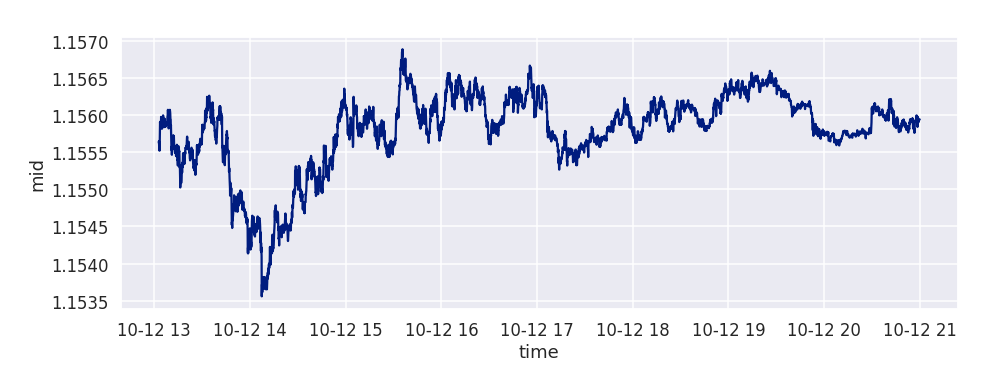

In [10]:
g1 = sns.lineplot(x='time', y='mid', data=df_lr)

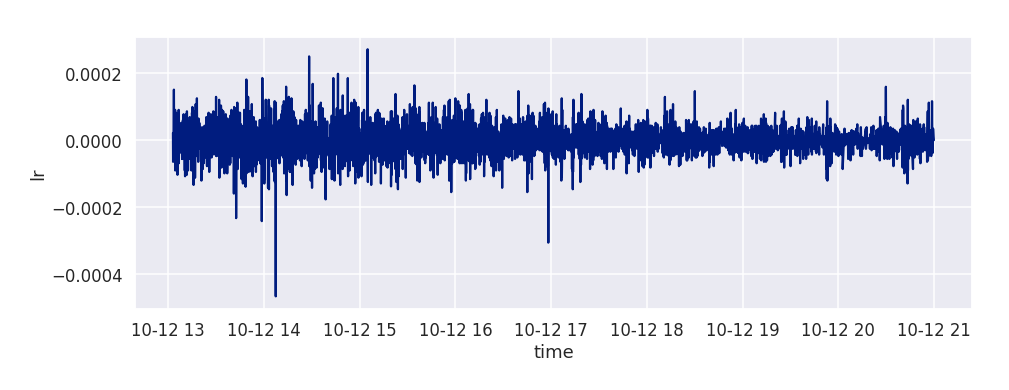

In [11]:
g2 = sns.lineplot(x='time', y='lr', data=df_lr)

<Figure size 1080x360 with 0 Axes>

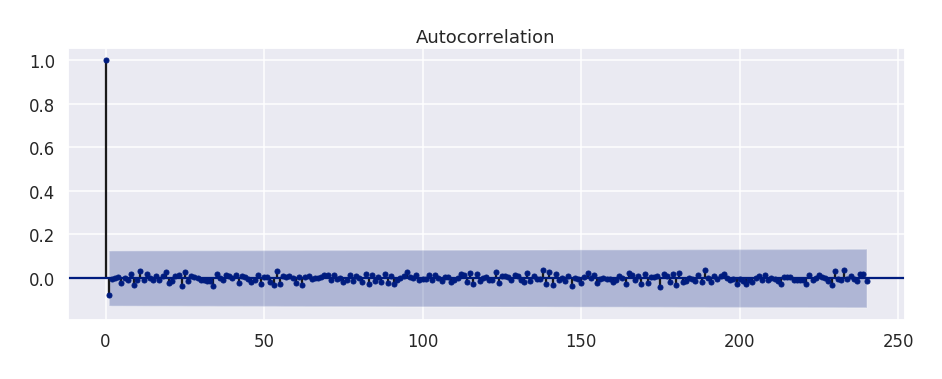

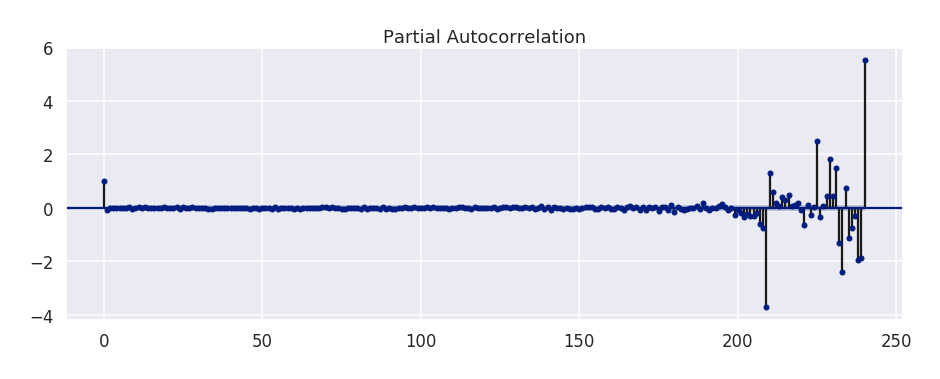

In [17]:
n_lags = 240
lr = df_lr.lr.dropna()
acf = sm.tsa.stattools.acf(lr, nlags=n_lags)
pacf = sm.tsa.stattools.pacf(lr, nlags=n_lags, method='ols')
g2 = plt.figure()
ax1 = g2.add_subplot()
g2 = sm.graphics.tsa.plot_acf(acf, lags=n_lags, ax=ax1)
ax2 = g2.add_subplot()
g2 = sm.graphics.tsa.plot_pacf(pacf, lags=n_lags, ax=ax2)